# COMSOL Simulation of the emitting spot size

- Original datafile in: /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data

- Settings in COMSOL were: -100 kV, 1mA ion beam current

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)


folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/'

# temporal resolution
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution'
files = os.listdir(folder)
files = [f for f in files if "hmesh" not in f]

files = [f for f in files if "particleData" in f]
fignames = files 
files = [f'{folder}/{f}' for f in files if "particleData" in f]


# # number of mesh elements
# outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution'
# files = os.listdir(folder)
# files = [f for f in files if "hmesh" in f]

# files = [f for f in files if "particleData" in f]
# fignames = files 
# print(fignames)
# files = [f'{folder}/{f}' for f in files if "particleData" in f]




In [2]:
for fname, figname in zip(files, fignames):
    print(fname, figname)
    data = pd.read_csv(fname, skiprows=7, index_col=0)
    cols = [c for c in data.columns if "2.5E" in c]
    data = data[cols]
    new_cols = []
    for c in cols:
        if 'qx' in c:
            new_cols.append('qx')
        if 'qy' in c:
            new_cols.append('qy')
        if 'qz' in c:
            new_cols.append('qz')
    data.columns = new_cols
    nbins = 200
    lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # zi = zi/np.max(zi)
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-3,4,1))
    plt.xticks(np.arange(-3,4,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
    print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')

    plt.show()
    
    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
    print(gauss(x0_y, *popt), A_y)

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, 0.20)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
    plt.text(-0.5, .12, r'\textbf{FWHM = 2.14 mm}', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.3,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
    plt.text(-0.5, .12, r'\textbf{FWHM = 2.60 mm}', fontsize=14)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.3,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}{figname}_YZ.pdf')
    plt.show()

/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//temporal_resolution02.MR.102.temporal_refinement.002.particleData.csv_YZ.pdf temporal_resolution02.MR.102.temporal_refinement.002.particleData.csv_YZ.pdf


ParserError: Error tokenizing data. C error: Expected 1 fields in line 19, saw 2


### Plot for thesis, run 003

In [3]:
zi.reshape(xi.shape).shape

NameError: name 'zi' is not defined

[[9.31650279e-51 3.99342338e-50 1.68556356e-49 ... 8.54492562e-32
  3.36964252e-32 1.31089339e-32]
 [4.77947162e-50 2.04047580e-49 8.57779019e-49 ... 3.79078595e-31
  1.50163898e-31 5.86816921e-32]
 [2.40293236e-49 1.02176774e-48 4.27799340e-48 ... 1.64639313e-30
  6.55151998e-31 2.57182946e-31]
 ...
 [1.70503791e-49 7.30794764e-49 3.08187482e-48 ... 2.77695588e-30
  1.11861762e-30 4.44542764e-31]
 [3.38253956e-50 1.45457081e-49 6.15459047e-49 ... 6.42230294e-31
  2.57589644e-31 1.01927423e-31]
 [6.56997149e-51 2.83456548e-50 1.20336414e-49 ... 1.45384725e-31
  5.80624985e-32 2.28771294e-32]]
0.158449846304488


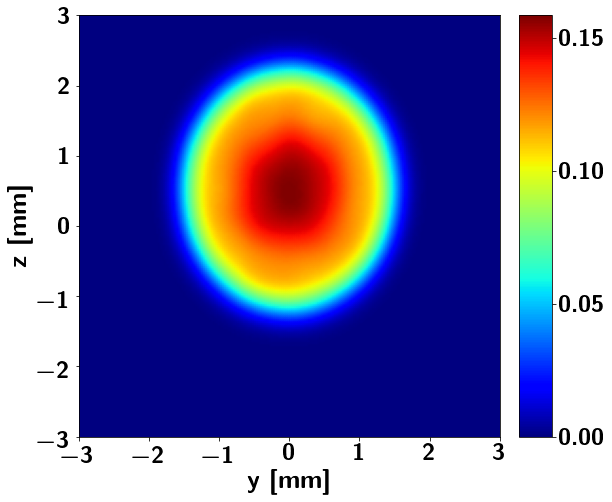

FWHM in x: 2.216759582289289
FWHM in y: 2.647468239462615
0.17038964978888457 0.17038964978888457


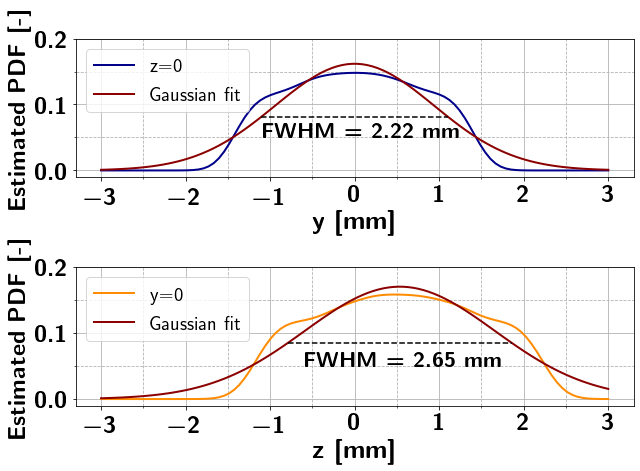

In [16]:
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.002.particleData.csv'
figname = '02_MR_102_temporal_refinement_002_particleData'
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/COMSOL_ion_beam'

data = pd.read_csv(fname, skiprows=7, index_col=0)
cols = [c for c in data.columns if "2.5E" in c]
data = data[cols]
new_cols = []
for c in cols:
    if 'qx' in c:
        new_cols.append('qx')
    if 'qy' in c:
        new_cols.append('qy')
    if 'qz' in c:
        new_cols.append('qz')
data.columns = new_cols
nbins = 200
lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
print(zi.reshape(xi.shape))
# plot
fs = 26

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-3,4,1))
plt.xticks(np.arange(-3,4,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
print(np.max(zi))
cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(f'{outfolder}/{figname}.pdf')

plt.show()

# query from the estimated pdf
qry_eval = np.linspace(-lim,lim,100)
eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

# fit FWHM
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


p0 = [1, 1, 1] # Initial guess for the parameters
# fit for parallel to x axis
X = qry_eval
Y = eval_x
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_x, x0_x, sigma_x = popt
Y_fit_x = gauss(X, *popt)
FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in x: {FWHM_x}')

# fit for parallel to y axis
X = qry_eval
Y = eval_y
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_y, x0_y, sigma_y = popt
FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in y: {FWHM_y}')
Y_fit_y = gauss(X, *popt)
print(gauss(x0_y, *popt), A_y)

f = plt.figure(1, figsize=(9, 6.5))
ylims = (-0.01, 0.20)
# top plot
plt.subplot(2, 1, 1)
plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
plt.text(-1.1, 0.05, r'\textbf{FWHM = 2.22 mm}', fontsize=fs-4)
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs-2)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="upper left",  fontsize=fs-6)
plt.ylim(ylims)
# bottom plot
plt.subplot(2, 1, 2)
plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
plt.text(-0.6, 0.05, r'\textbf{FWHM = 2.65 mm}', fontsize=fs-4)
plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs-2)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="upper left",  fontsize=fs-6)
# leg1.set_title(r"Experiment number", prop = {'size': 12})
plt.tight_layout()
plt.ylim(ylims)
plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
plt.show()

### One file plot

0.18260418420883107


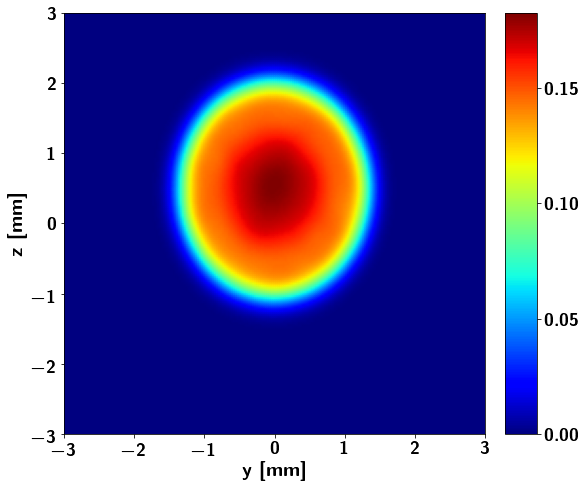

FWHM in x: 2.1223695675453524
FWHM in y: 2.445700041889826
0.19979337612011788 0.19979337612011788


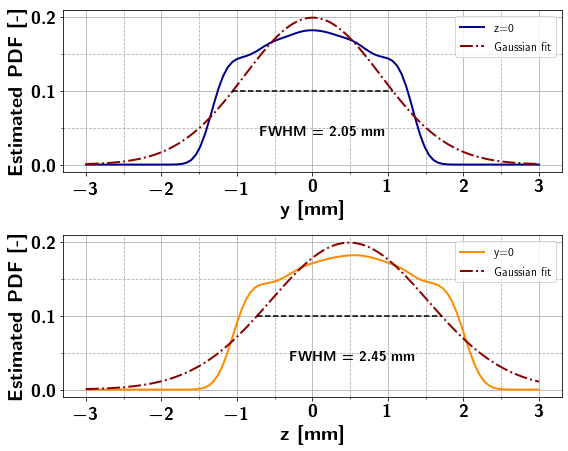

In [3]:
figname = '02.MR.102.temporal_refinement.003_80kV_5k_12mmEE.particleData.csv'
fname = f'/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/{figname}'
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/single_files'

data = pd.read_csv(fname, skiprows=7, index_col=0)
cols = [c for c in data.columns if "2.5E" in c]
data = data[cols]
new_cols = []
for c in cols:
    if 'qx' in c:
        new_cols.append('qx')
    if 'qy' in c:
        new_cols.append('qy')
    if 'qz' in c:
        new_cols.append('qz')
data.columns = new_cols
nbins = 200
lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# zi = zi/np.max(zi)
# plot
fs = 20

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-3,4,1))
plt.xticks(np.arange(-3,4,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
print(np.max(zi))
cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(f'{outfolder}/{figname}.pdf')

plt.show()

# query from the estimated pdf
qry_eval = np.linspace(-lim,lim,100)
eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot
# maximum 
idx_max = np.argmax(eval_y)
y_max = qry_eval[idx_max]
eval_x = [k.evaluate([x,y_max])[0] for x in qry_eval] # for z = 0 in the upper plot

# fit FWHM
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


p0 = [1, 1, 1] # Initial guess for the parameters
# fit for parallel to x axis
X = qry_eval
Y = eval_x
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_x, x0_x, sigma_x = popt
Y_fit_x = gauss(X, *popt)
FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in x: {FWHM_x}')

# fit for parallel to y axis
X = qry_eval
Y = eval_y
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_y, x0_y, sigma_y = popt
FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in y: {FWHM_y}')
Y_fit_y = gauss(X, *popt)
print(gauss(x0_y, *popt), A_y)

f = plt.figure(1, figsize=(8, 6.4))
ylims = (-0.01, 0.21)
# top plot
plt.subplot(2, 1, 1)
plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
plt.plot(qry_eval, Y_fit_x, '-.',color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
plt.text(-0.7, .04, r'\textbf{FWHM = 2.05 mm}', fontsize=14)
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
plt.ylim(ylims)
# bottom plot
plt.subplot(2, 1, 2)
plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
plt.plot(qry_eval, Y_fit_y, '-.',color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
plt.text(-0.3, .04, r'\textbf{FWHM = 2.45 mm}', fontsize=14)
plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
# leg1.set_title(r"Experiment number", prop = {'size': 12})
plt.tight_layout()
plt.ylim(ylims)
plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
plt.savefig(f'{outfolder}/{figname}_1200.png',dpi=1200)
plt.show()

# Beam halo

In [4]:
from scipy.integrate import simps
from scipy.integrate import trapz
qry_eval = np.linspace(-lim,lim,100) # evaluation points

# total sum!
integrals = [] # laist of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        val = k.evaluate([x,y])[0] 
        vals.append(val)
#     integral = trapz(vals, qry_eval)

    integral = np.asarray(vals).sum()
    integrals.append(integral)
total_sum = np.asarray(integrals).sum()

# total integral
integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        val = k.evaluate([x,y])[0] 
        vals.append(val)
    integral = trapz(vals, qry_eval)
    integrals.append(integral)
total_integral = np.asarray(integrals).sum()

total_sum, total_integral

(272.24999999191033, 16.4999999980512)

In [5]:
# integral and sum in the center only
r = 2/2 # mm
integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        if np.sqrt(x**2+y**2) <= r:
            val = k.evaluate([x,y])[0] 
            vals.append(val)
#     integral = trapz(vals, qry_eval)

    integral = np.asarray(vals).sum()
    integrals.append(integral)
sum_in_circle = np.asarray(integrals).sum()

integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    x_int = []
    for y in qry_eval:
        if np.sqrt(x**2+y**2) <= r:
            val = k.evaluate([x,y])[0] 
            vals.append(val)
            x_int.append(y)
    integral = trapz(vals, np.asarray(x_int))

#     integral = np.asarray(vals).sum()
    integrals.append(integral)
integral_in_circle = np.asarray(integrals).sum()

sum_in_circle, integral_in_circle

(130.93319081930449, 7.665944026934139)

In [6]:
sum_in_circle/total_sum, integral_in_circle/total_integral

(0.4809299938409368, 0.4646026683539125)

## Reverse x and y


In [7]:
from scipy.integrate import simps
from scipy.integrate import trapz
qry_eval = np.linspace(-lim,lim,100) # evaluation points

# total sum!
integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        val = k.evaluate([y,x])[0] 
        vals.append(val)
#     integral = trapz(vals, qry_eval)

    integral = np.asarray(vals).sum()
    integrals.append(integral)
total_sum = np.asarray(integrals).sum()

# total integral
integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        val = k.evaluate([y,x])[0] 
        vals.append(val)
    integral = trapz(vals, qry_eval)
    integrals.append(integral)
total_integral = np.asarray(integrals).sum()

total_sum, total_integral

(272.2364203648802, 16.49917699181092)

In [8]:
# integral and sum in the center only
r = 2./2 # mm
integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    for y in qry_eval:
        if np.sqrt(x**2+y**2) <= r:
            val = k.evaluate([y,x])[0] 
            vals.append(val)
#     integral = trapz(vals, qry_eval)

    integral = np.asarray(vals).sum()
    integrals.append(integral)
sum_in_circle = np.asarray(integrals).sum()

integrals = [] # list of the integrals
for x in (qry_eval-qry_eval[idx_max]):
    vals = []
    x_int = []
    for y in qry_eval:
        if np.sqrt(x**2+y**2) <= r:
            val = k.evaluate([y,x])[0] 
            vals.append(val)
            x_int.append(y)
    integral = trapz(vals, np.asarray(x_int))

#     integral = np.asarray(vals).sum()
    integrals.append(integral)
integral_in_circle = np.asarray(integrals).sum()

sum_in_circle, integral_in_circle

(130.9105326669855, 7.664252329494565)

In [9]:
sum_in_circle/total_sum, integral_in_circle/total_integral

(0.480870753779106, 0.46452331127174307)

In [10]:
x = qry_eval-qry_eval[idx_max]
y = np.asarray(eval_y)

total = np.sum(y)

ii = np.where((x <= 1) & (x >= -1))[0]
np.sum(y[ii])/total

0.683829359221491

0.7927990921203318

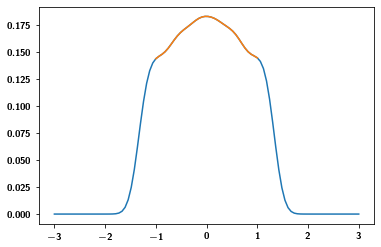

In [11]:
x = qry_eval
y = np.asarray(eval_x)

total = np.sum(y)

ii = np.where((x <= 1) & (x >= -1))[0]


plt.plot(x, y)
plt.plot(x[ii], y[ii])
np.sum(y[ii])/total

In [12]:
lim = 3
nbins = 200
xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j] # x and y are in the plot
data_x = data['qy'].values # in the plot
data_y = data['qz'].values # in the plot
data_y

array([-0.0786079 , -0.03085467,  0.01703185, ...,  1.62764295,
        1.66108645,  1.62812447])

In [ ]:
# loop through the samples and increase counts in the zi by one if the sample is in this range
zi = np.zeros(xi.shape) # initialize the values to 0
for x, y in zip(data_x, data_y):
    print(x,y)


In [14]:
nbins = 300

xi = np.linspace(-3,3,nbins)
yi = np.linspace(-3,3,nbins)
zi = np.zeros([nbins,nbins]) # initialize the values to 0

# x, y = data_x[0], data_y[0]
for x, y in zip(data_x, data_y):
    closest_x = np.argmin(np.abs(x-xi))
    closest_y = np.argmin(np.abs(y-yi))
    zi[closest_y][closest_x] = zi[closest_y][closest_x] + 1

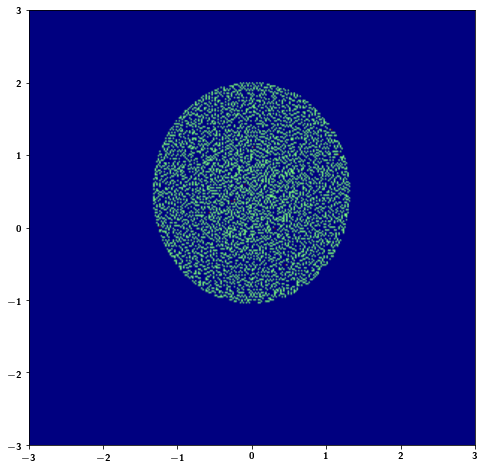

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
p = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.jet)


In [67]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(df['Date'], df['Value_change'].values, width=0.8, align='center', color='darkblue')
plt.show()

5000.0

In [89]:
zi[149][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [85]:
np.argmin(np.abs(xi-0))

149

# Alternate plot

In [17]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)

fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/4mm_fillet/particleData/50kparticles.txt'

data = pd.read_csv(fname, skiprows=8, index_col=0, delimiter='\s+', header=None)
data.columns = ['qx', 'qy', 'qz']


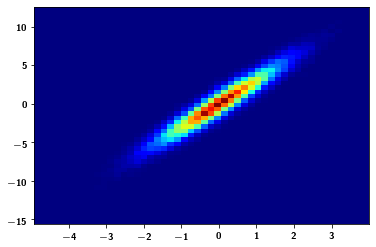

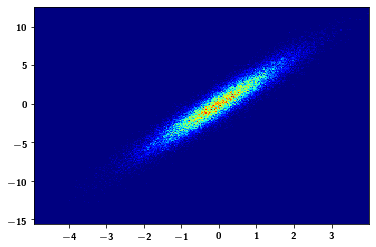

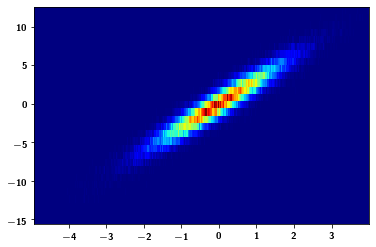

In [18]:
# create data
x = np.random.normal(size=50000)
y = x * 3 + np.random.normal(size=50000)
 
# Big bins
plt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)
plt.show()
 
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
plt.show()
 
# If you do not set the same values for X and Y, the bins aren't square !
plt.hist2d(x, y, bins=(300, 30), cmap=plt.cm.jet)
 
plt.show()


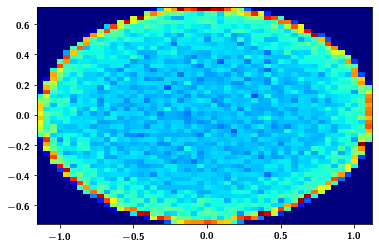

In [23]:
x = data['qz'].values
y = data['qy'].values

p = plt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)
plt.show()

In [43]:
p[1]

array([-1.16300879, -0.99411574, -0.8252227 , -0.65632966, -0.48743662,
       -0.31854357, -0.14965053,  0.01924251,  0.18813555,  0.3570286 ,
        0.52592164,  0.69481468,  0.86370772,  1.03260076,  1.20149381,
        1.37038685,  1.53927989,  1.70817293,  1.87706598,  2.04595902,
        2.21485206])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.40917114506805313


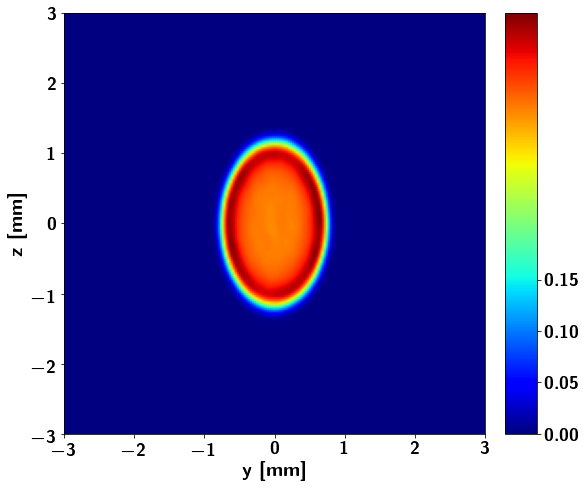

In [21]:
nbins = 200
lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
print(zi.reshape(xi.shape))
# plot
fs = 20

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-3,4,1))
plt.xticks(np.arange(-3,4,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
print(np.max(zi))
cbar.ax.tick_params(labelsize=fs-2)
# plt.savefig(f'{outfolder}/{figname}.pdf')

plt.show()